In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.optim as optim
from torchvision import transforms, models
import os

In [2]:
vgg = models.vgg19(pretrained = True).features

for param in vgg.parameters():
    param.requires_grad_(False) #Freezing the weights that we do not want to change to 

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 52.6MB/s]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
def load_image(img_path, max_size=400, shape = None):
    
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size)>max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                         transforms.Resize(size),
                         transforms.ToTensor(),
                         transforms.Normalize((0.485,0.456,0.406),
                                             (0.229,0.224,0.225))])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [5]:
os.listdir("../input/")

['content.jpg', 'style.jpg']

In [6]:
content = load_image('../input/content.jpg').to(device)

#Resize style,makes code easier
style = load_image('../input/style.jpg',shape=content.shape[-2:]).to(device)

In [7]:
#helper function for un-normalizing an image
# and converting it from a tensor image to aNumpy image for display

def im_convert(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))
    image = image.clip(0,1)
    
    return image

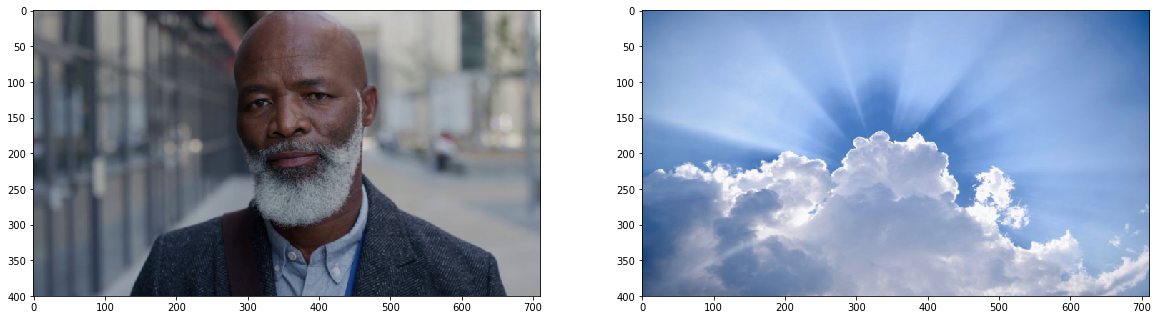

In [8]:
#display the images
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))

#content and style ims side-by-side

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))


In [9]:
#VGG19 Layers

#This is where i pick up layers for feature exraction

def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0':'conv1_1',
                  '5':'conv2_1',
                  '10':'conv3_1',
                  '19':'conv4_1',  ##content representation
                  '21':'conv4_2',
                  '28':'conv5_1'}

    features = {}
    x = image
    
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features
        
    

In [10]:
# the gram matrix

def gram_matrix(tensor):
    
      #get the batch_size,depth,height,and width of the tensor
    _, d, h, w = tensor.size()
    
    #reshape so we're multiplying the features for each channel
    tensor = tensor.view(d,h * w)
    
    #calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [11]:
#Combining all


content_features = get_features(content,vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)



In [12]:
# Loss and weight

#weight for each style layer
#weighting earlier layer will result in larger style artifacts
style_weights = {'conv1_1':1.,
                 'conv2_1':0.8,
                 'conv3_1':0.5,
                 'conv4_1':0.3,
                 'conv5_1':0.1,}

content_weight = 1 #alpha
style_weight = 1 #beta #style loss should be much
                         #larger if we do not want it to 
                         # overlap our image


Total loss: 29.636144638061523


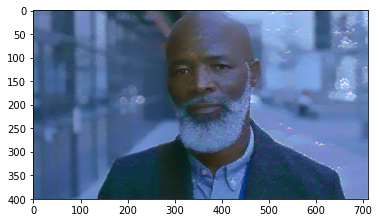

In [13]:
#for displaying the target image,intermittently
show_every = 400

#iterative hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 500 #decide how many iterations to update your image(5000)

for ii in range(1, steps+1):
    
    target_features = get_features(target,vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    
    for layer in style_weights:
        
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d,h,w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        #add to the style loss
        style_loss += layer_style_loss/(d*h*w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    #update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    #display intermediate images and print the loss
    if ii % show_every == 0:
        print('Total loss:',total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

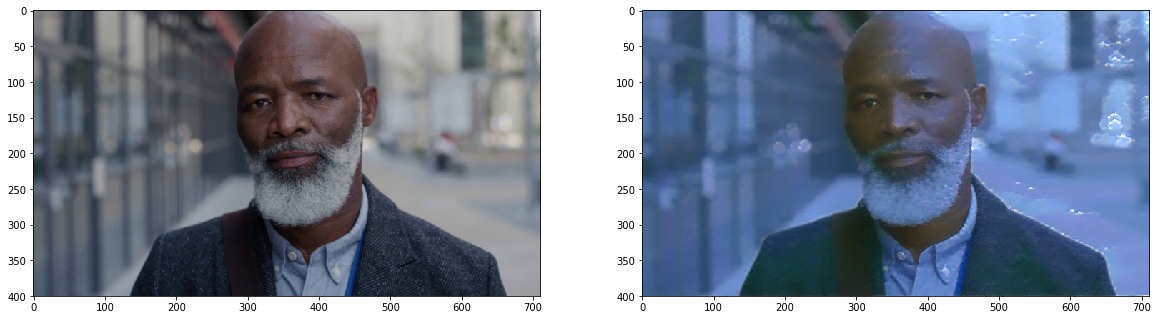

In [14]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))